In [110]:
import pandas as pd 
import numpy as np

# spatial
import geopandas as gpd
import shapely
from shapely.geometry import Point
import contextily as cx
import folium
import leafmap.foliumap as leafmap

import seaborn as sns
import matplotlib.pyplot as plt

# Image Size
from IPython.core.pylabtools import figsize
figsize(8,8)

In [111]:
# Loading datasets
df = pd.read_csv('https://raw.githubusercontent.com/amnesty-crisis-evidence-lab/decode-surveillance-nyc/main/data/counts_per_intersections.csv')
gdf = gpd.read_file('../data/NYC_Surveillance_SHP/nyc_surveillance_cameras.shp')
hexGrid = gpd.read_file('../data/HexGrid_Pop_And_Cameras/hexgrid_population.shp')

# loading regular grid for landscan populations
regGrid = gpd.read_file('../data/Pop_Grid_4HotSpot/reg_grid_population.shp')

In [3]:
print('Total number of intersections surveyed in NYC:',df['n_cameras_median'].count())
print('Total camera counts attached to buildings:',df['attached_building_median'].sum())
print('Total cameras attatched to street lights, traffic signals, or poles:',df['attached_street_median'].sum())

Total number of intersections surveyed in NYC: 43406
Total camera counts attached to buildings: 22133
Total cameras attatched to street lights, traffic signals, or poles: 3317


#### Cameras attached to streetlights, traffic signals or poles that are also dome type and so most likely to be the NYPD or the Department of Transportation.

In [4]:
print('Total cameras attatched to street lights, traffic signals, or poles:',df['type_dome_median'].sum())

Total cameras attatched to street lights, traffic signals, or poles: 2266


In [5]:
df['BoroName'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

BoroName
Queens           37.7%
Brooklyn         23.9%
Staten Island    14.9%
Bronx            14.4%
Manhattan         9.1%
Name: proportion, dtype: object

#### Boroughs most surveilled?

In [6]:
surveilled_df = df[df['n_cameras_median'] > 0]

In [7]:
surveilled_boros = surveilled_df.groupby(['BoroName'])[['n_cameras_median']].sum().reset_index()

In [8]:
surveilled_boros['Percentage'] = 100 * surveilled_boros['n_cameras_median']  / surveilled_boros['n_cameras_median'].sum()

In [9]:
surveilled_boros['Percentage'] = surveilled_boros['Percentage'].round(0)

In [10]:
surveilled_boros.sort_values('Percentage')

BoroName  n_cameras_median  Percentage
4  Staten Island              1183         4.0
0          Bronx              4103        14.0
2      Manhattan              4266        15.0
3         Queens              8935        31.0
1       Brooklyn             10463        36.0

#### Spatial exploration of surveilled neighborhoods

In [11]:
surveilled_gdf = gdf[gdf['n_cameras_'] > 0]

(-74.27864826923673, -73.67335148194636, 40.48144704836759, 40.93301864411539)

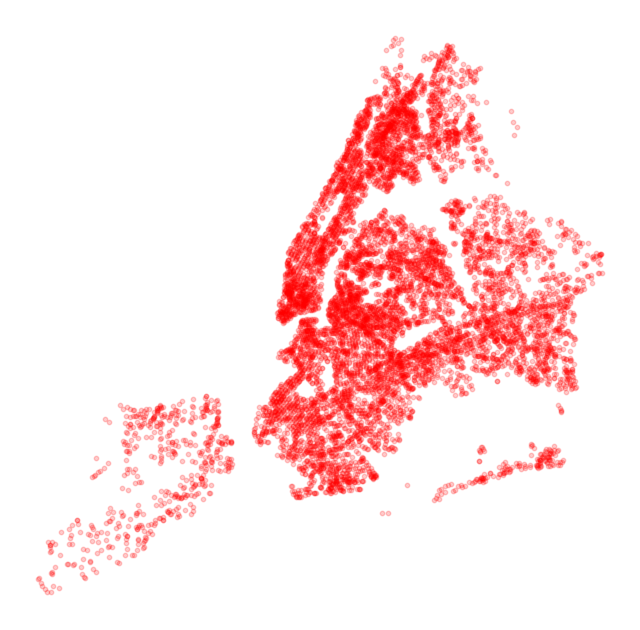

In [12]:

ax = surveilled_gdf.sample(10000).plot(alpha=0.2, markersize=10, color='red')

# turn off axis
ax.axis('off')

(-74.27864826923673, -73.67335148194636, 40.48144704836759, 40.93301864411539)

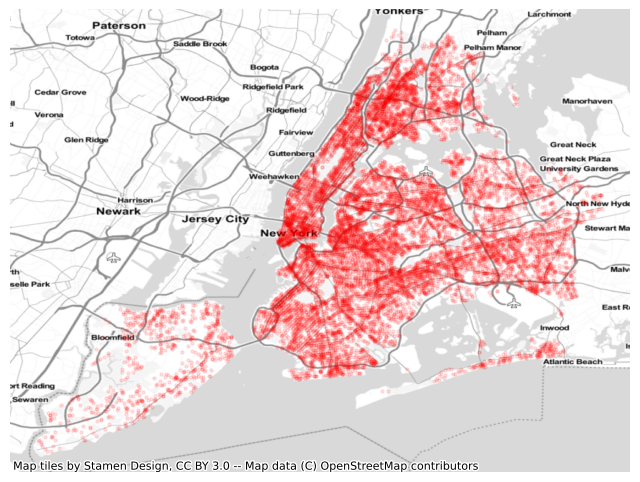

In [13]:
# Dot Density Map
ax = surveilled_gdf.plot(alpha=0.1, markersize=5, color='red')

basemap = cx.providers.Stamen.TonerLite

cx.add_basemap(ax,
               crs=gdf.crs,
               source=basemap)
ax.axis('off')

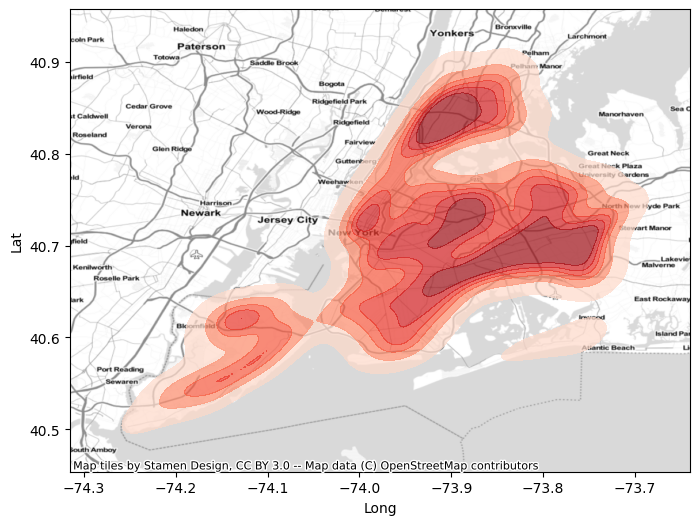

In [14]:
sns.kdeplot(data=gdf, 
            x='Long', 
            y='Lat', 
            fill=True, 
            n_levels=7,
            cmap='Reds',
            alpha=0.7,
            bw_adjust=1.0,
            levels=25)
basemap = cx.providers.Stamen.TonerLite
cx.add_basemap(plt.gca(), crs=gdf.crs.to_string(), source=basemap)


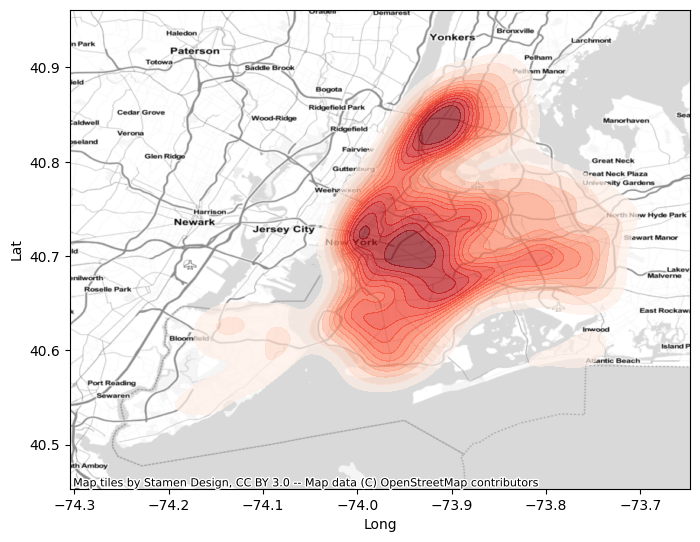

In [15]:
sns.kdeplot(data=surveilled_gdf, 
            x='Long', 
            y='Lat', 
            fill=True, 
            n_levels=14,
            cmap='Reds',
            alpha=0.7,
            bw_adjust=1.0,
            levels=25)
basemap = cx.providers.Stamen.TonerLite
cx.add_basemap(plt.gca(), crs=gdf.crs.to_string(), source=basemap)

<hr>

In [16]:
hexGrid.head(3)

index       index_righ  n_cameras_    area_sq_mi  daytime_po    daytime__1   
0  200.0  882a100883fffff        32.0  3.059500e-11     30956.0  1.011815e+15  \
1    NaN  882a10632bfffff         NaN  3.044900e-11         0.0  0.000000e+00   
2  295.0  882a100c05fffff        60.0  3.052800e-11      8742.0  2.863576e+14   

   nighttime_    nighttim_1                                           geometry  
0     40367.0  1.319419e+15  POLYGON ((-73.97033 40.79441, -73.96592 40.791...  
1         0.0  0.000000e+00  POLYGON ((-74.22508 40.64455, -74.22065 40.641...  
2      7673.0  2.513409e+14  POLYGON ((-73.89094 40.73306, -73.88653 40.729...

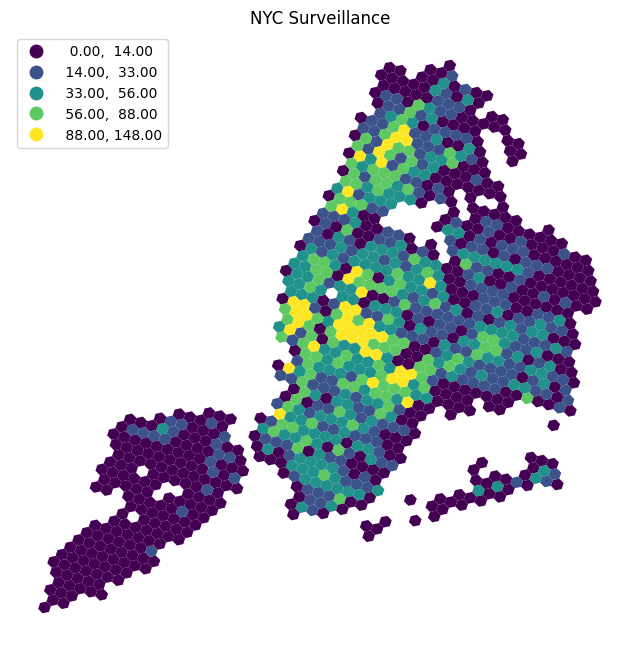

In [17]:
ax = hexGrid.plot(column='n_cameras_', scheme='natural_breaks', legend=True, legend_kwds={'loc': 'upper left'})
ax.axis('off')
ax.set_title('NYC Surveillance');

In [18]:
# hexGrid['n_cameras_'] = hexgrid_gdf['n_cameras_'].fillna(0)


In [19]:
hexGrid.columns

Index(['index', 'index_righ', 'n_cameras_', 'area_sq_mi', 'daytime_po',
       'daytime__1', 'nighttime_', 'nighttim_1', 'geometry'],
      dtype='object')

### Testing if there is a correlation between number of cameras and daytime population 

The Pearson correlation coefficient between n_cameras_median and daytime_population. If the p-value is less than 0.05, we can conclude that there is a statistically significant correlation between the two variables.

Given the correlation coefficient of 0.43 and a p-value of 0.00. This indicates a moderate positive correlation between n_cameras and daytime_population. A correlation coefficient of 0.43 indicates a moderate positive correlation, meaning that as the number of cameras increases, so does the daytime population. The p-value of 0.00 suggests that this correlation is statistically significant.

In [20]:
from scipy.stats import pearsonr


In [21]:
# dropping nulls, assuming they are water body of nyc
hexGrid.dropna(inplace=True)

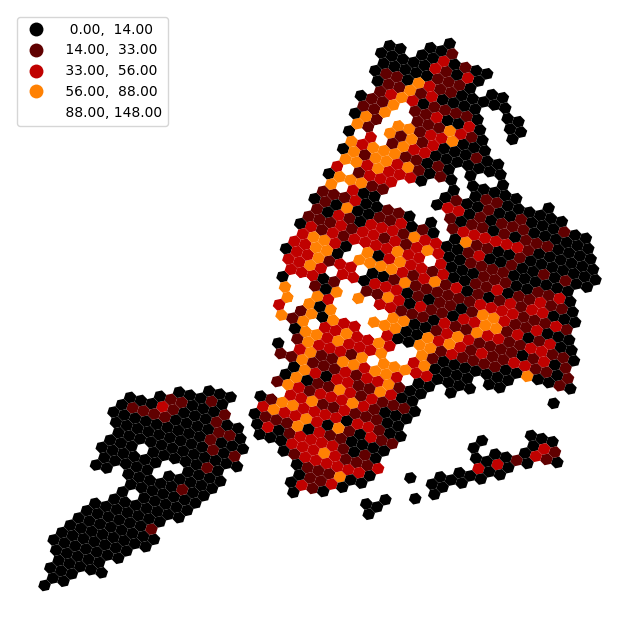

In [22]:
# double checking
ax = hexGrid.plot(column='n_cameras_', 
                  scheme='natural_breaks', 
                  legend=True, 
                  legend_kwds={'loc': 'upper left'},
                  cmap='gist_heat'
                  )
ax.axis('off')
# ax.set_title('NYC Surveillance');

# save as png with transparent background

plt.savefig('nyc_surveillance.png', bbox_inches='tight', transparent=True)


In [23]:
corr_coef, p_value = pearsonr(hexGrid['n_cameras_'], hexGrid['daytime_po'])


print(f"Correlation coefficient: {corr_coef:.2f}, p-value: {p_value:.2f}")

Correlation coefficient: 0.43, p-value: 0.00


### Testing if there is a correlation between number of cameras and night time population 

The correlation coefficient of 0.64 and a p-value of 0.00 indicate a significant positive correlation between the variables n_cameras and night time population.

In [24]:
# double checking

corr_coef, p_value = pearsonr(hexGrid['n_cameras_'], hexGrid['nighttime_'])


print(f"Correlation coefficient: {corr_coef:.2f}, p-value: {p_value:.2f}")



Correlation coefficient: 0.64, p-value: 0.00


### Spatial Autocorrelation on surveilled_gdf
Is spatial autocorrelation present across the whole map? (Global)

Is spatial autocorrelation present at individual locations? (Local)


In [25]:
surveilled_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
surveilled_gdf.head(3)

PanoramaId  n_cameras_  attached_s  attached_b  attached_u   
4   --fUkaf5nn1-bm4KiJ9pVA           1           0           1           0  \
9   -0KlvkzMEDcLyTePpuY3sg           5           0           5           0   
19  -1CEoQy0p4_FwdTHqNigMQ           1           0           0           0   

    type_dome_  type_bulle  type_unkno    n_camera_1 attached_1  ...   
4            0           0           0        2 vs 1  Unanimous  ...  \
9            0           0           0  All disagree  Unanimous  ...   
19           0           0           0  All disagree     2 vs 1  ...   

   type_dom_1 type_bul_1 type_unk_1        Lat       Long   
4   Unanimous  Unanimous  Unanimous  40.611084 -74.162803  \
9   Unanimous  Unanimous  Unanimous  40.692888 -73.956733   
19     2 vs 1  Unanimous  Unanimous  40.883196 -73.882214   

                                      geometry_p       BoroName   
4   POINT (-74.16280280196275 40.61108412672856)  Staten Island  \
9   POINT (-73.95673315914595 40.69288765636261)       Brooklyn   
19  POINT (-73.88221381018394 40.88319613843642)          Bronx   

                                                  URL ImageDate   
4   https://www.google.com/maps/@?api=1&map_action...   2019-09  \
9   https://www.google.com/maps/@?api=1&map_action...   2020-11   
19  https://www.google.com/maps/@?api=1&map_action...   2019-11   

                      geometry  
4   POINT (-74.16280 40.61108)  
9   POINT (-73.95673 40.69289)  
19  POINT (-73.88221 40.88320)  

[3 rows x 22 columns]

In [27]:
surveilled_gdf.shape

(14100, 22)

In [28]:
surveilled_gdf['n_cameras_'].value_counts()

n_cameras_
1     6864
2     3664
3     1700
4      883
5      460
6      244
7      124
8       72
9       34
10      28
11      12
12       7
15       4
16       1
17       1
14       1
13       1
Name: count, dtype: int64

In [29]:
def make_grid(gdf, n_cells):
    gdf = gdf.copy()
    xmin, ymin, xmax, ymax= gdf.total_bounds
    cell_size = (xmax-xmin)/n_cells
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=gdf.crs)
    return grid

In [30]:
grid = make_grid(surveilled_gdf, n_cells=70)

In [31]:
def rasterize(gdf, grid, column, plot=True, save_path=None):
    # Spatial join the GeoDataFrame with the grid
    merged = gpd.sjoin(gdf, grid, how='left', op='within')

    # Group by the hexagon cell and sum the column of interest
    dissolved = merged.groupby('index_right')[column].sum().reset_index()

    # Merge the dissolved data with the grid
    grid = grid.merge(dissolved, left_index=True, right_on='index_right', how='left')

    # Plot the grid
    if plot:
        fig, ax = plt.subplots(figsize=(12, 8))
        grid.plot(column=column, cmap='viridis', ax=ax, edgecolor='grey', legend=True)
        ax.axis('off')
        cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=gdf.crs)
        plt.show()

    # Save the result to a shapefile
    if save_path is not None:
        grid.to_file(save_path)

    return grid

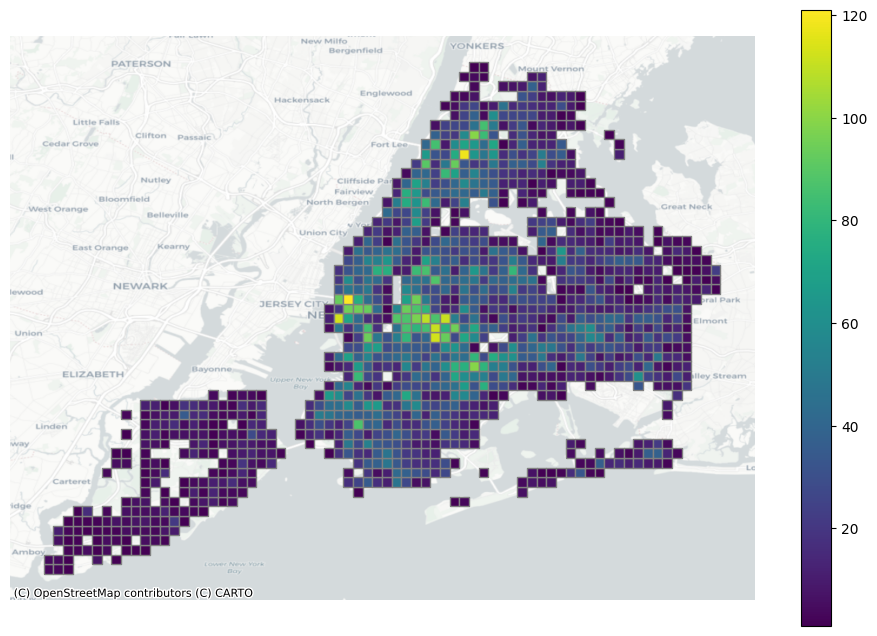

In [32]:
raster_grid = rasterize(surveilled_gdf, grid, column='n_cameras_')


In [34]:
raster_grid['n_cameras_'].isna().value_counts()

n_cameras_
True     2653
False    1235
Name: count, dtype: int64

In [109]:
# export raster grid to clip population density and perform 
# hot/cold spot analysis
# raster_grid.to_file("surveillance_grid_4hotspot.shp")

In [35]:
raster_grid = raster_grid.dropna(subset=['n_cameras_'])

In [36]:
raster_grid['n_cameras_'].isna().value_counts()

n_cameras_
False    1235
Name: count, dtype: int64

In [37]:
# spatial autocorrelation in surveillance cameras 
from pysal.lib import weights 

In [38]:
# generating weights based on queen-contiguity
w = weights.Queen.from_dataframe(raster_grid)

In [39]:
# view row-standardized spatial weights matrix
# w.weights

In [40]:
# row standardize the weights matrix
w.transform = 'R'

('WARNING: ', 46, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 688, ' is an island (no neighbors)')


In [41]:
# perform hypothesis test for global spatial autocorrelation using
# Global Moran's I 
from pysal.explore import esda

In [42]:
moran = esda.moran.Moran(raster_grid['n_cameras_'], w, permutations=9999)

In [43]:
moran.I

0.5702783488858983

In [44]:
moran.p_sim

0.0001

##### The simulated p-value is very low, so we can reject the null hypothesis that there is no spatial autocorrelation and conclude that spatial autocorrelation is in fact present. We don't know of what kind or where yet.  

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.57', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.57)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

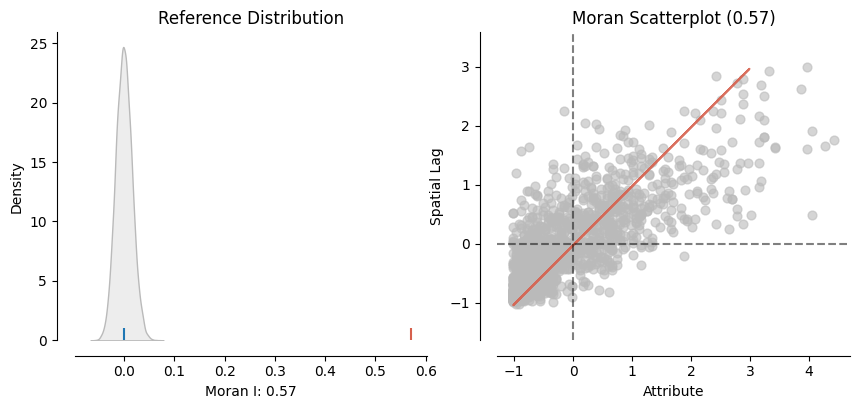

In [46]:
from splot.esda import plot_moran
plot_moran(moran)

The plot shows a positive slope, it indicates a positive spatial autocorrelation, meaning that similar values tend to cluster together on the map. Conversely, a negative slope indicates a negative spatial autocorrelation, meaning that dissimilar values tend to cluster together.


The Moran's I statistic summarizes the degree of spatial autocorrelation in the variable being analyzed. If Moran's I is close to +1, it indicates a high degree of positive spatial autocorrelation, while a value close to -1 indicates a high degree of negative spatial autocorrelation. A value close to 0 indicates no spatial autocorrelation.


In [75]:
# performing hypothesis test for global spatial autocorrelation using 
# getis-ord g


# in order to use the g statistic, we must use distance based weights
distance_band = 1000
w_dist = weights.DistanceBand.from_dataframe(raster_grid, distance_band)

In [78]:
# calculate the getis-ords g statistic
getisord = esda.getisord.G(raster_grid['n_cameras_'], w_dist, permutations=9999)

A Getis-Ord G statistic of 1.0 indicates a higher degree of spatial clustering of the variable of interest (in this case, the number of cameras) compared to what would be expected by chance. The value of 1.0 means that the observed sum of spatially weighted values is one standard deviation above the expected value under the null hypothesis of spatial randomness. The larger the value of G, the stronger the clustering of the variable. On the other hand, a negative value of G would indicate a spatial pattern of dispersion or segregation.

In [79]:
getisord.G

1.0

In [80]:
# view standardized z-score of the g statistics
# not sure why this the result is nan
getisord.z_sim

nan

In [81]:
getisord.p_sim

0.0001

In [82]:
# test for local spatial autocorrelation using local moran's I
local_moran = esda.moran.Moran_Local(raster_grid['n_cameras_'], w)

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <Axes: >, <Axes: >], dtype=object))

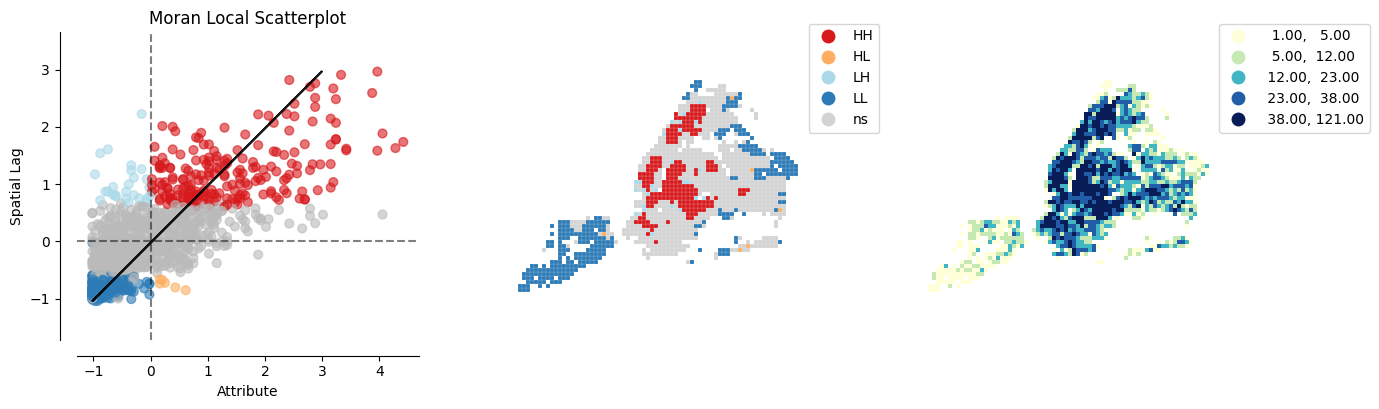

In [83]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(local_moran, raster_grid, 'n_cameras_', p=0.05)

In [84]:
# get the clustees and outliers 
raster_grid['local_moran_Is'] = local_moran.Is

In [86]:
raster_grid['local_moran_p_value'] = local_moran.p_sim

In [87]:
raster_grid['local_moran_quadrant'] = local_moran.q

In [93]:
# get the statistically significant clusters and outliers 
alpha = 0.05
hotspots = raster_grid.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = raster_grid.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = raster_grid.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamond = raster_grid.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

(-74.27864826923674, -73.67335148194591, 40.48114138731302, 40.93943752626137)

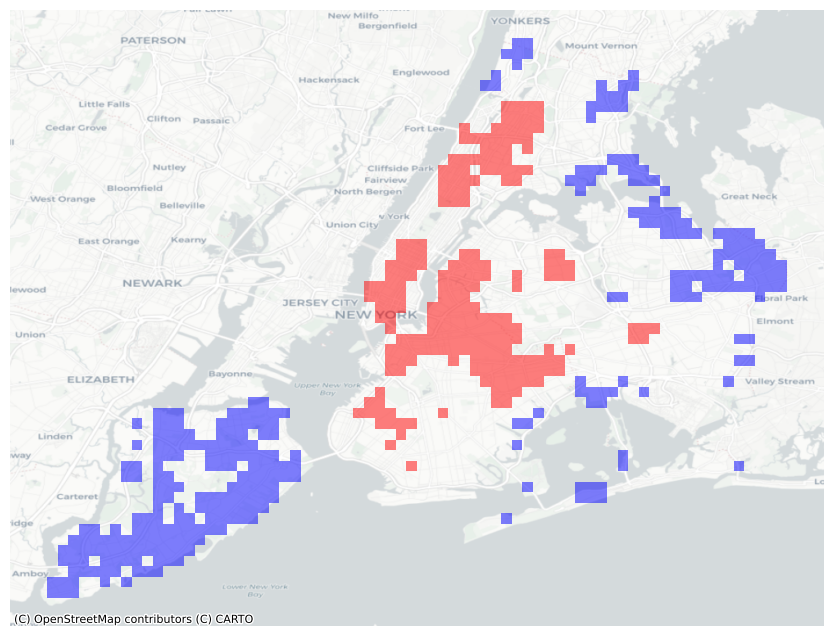

In [107]:
fig, ax = plt.subplots(figsize=(16,8))
raster_grid.plot(ax=ax, facecolor='none', alpha=0)
hotspots.plot(color='red', ax=ax, label='Hot Spot', alpha=.5)
coldspots.plot(color='blue',ax=ax, label='Cold Spot',alpha=.5)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=4326)
ax.axis('off')
# plt.savefig('nyc_surveillance_hotspot_analysis.png', bbox_inches='tight', transparent=True)


### Hot/cold spot analysis for landscan population

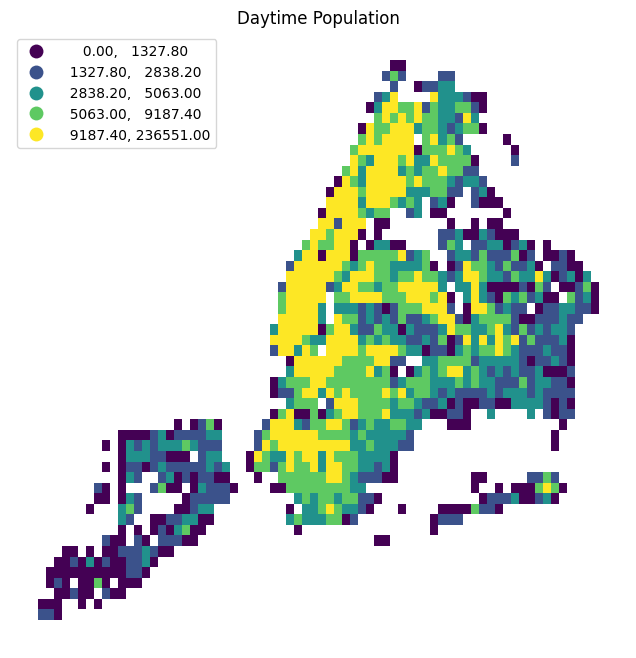

In [156]:
ax = regGrid.plot(column='daytime_po', 
                  scheme='quantiles', 
                  legend=True, 
                  legend_kwds={'loc': 'upper left'})
ax.axis('off')
ax.set_title('Daytime Population');


In [130]:
regGrid['n_cameras_'].isna().value_counts()

n_cameras_
False    1235
Name: count, dtype: int64

In [131]:
w2 = weights.Queen.from_dataframe(regGrid)

In [132]:
# w2.weights

In [133]:
# row standardize the weights matrix
w2.transform = 'R'

('WARNING: ', 46, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 688, ' is an island (no neighbors)')


In [134]:
moran2 = esda.moran.Moran(regGrid['n_cameras_'], w, permutations=9999)

In [135]:
moran2.I

0.5702783488858983

In [136]:
moran2.p_sim

0.0001

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.57', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.57)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

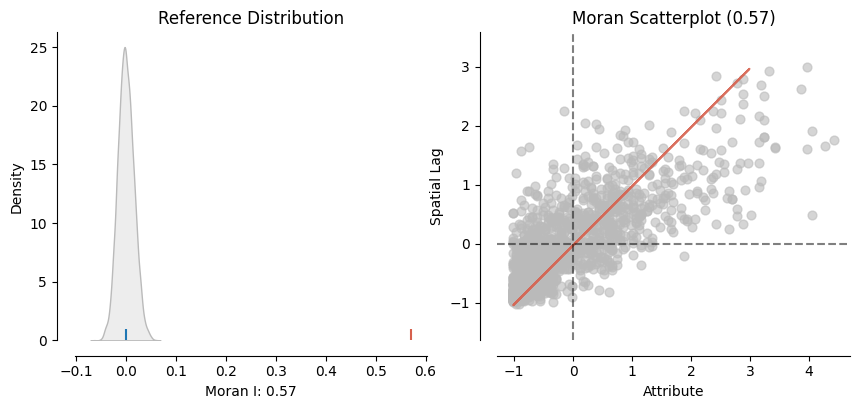

In [137]:
plot_moran(moran2)

In [138]:
w2_dist = weights.DistanceBand.from_dataframe(regGrid, distance_band)

In [139]:
getisord2 = esda.getisord.G(regGrid['daytime_po'], w_dist, permutations=9999)

In [140]:
getisord2.G

1.0

In [141]:
getisord2.z_sim

nan

In [142]:
getisord2.p_sim

0.0001

In [143]:
local_moran2 = esda.moran.Moran_Local(regGrid['daytime_po'], w2)

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <Axes: >, <Axes: >], dtype=object))

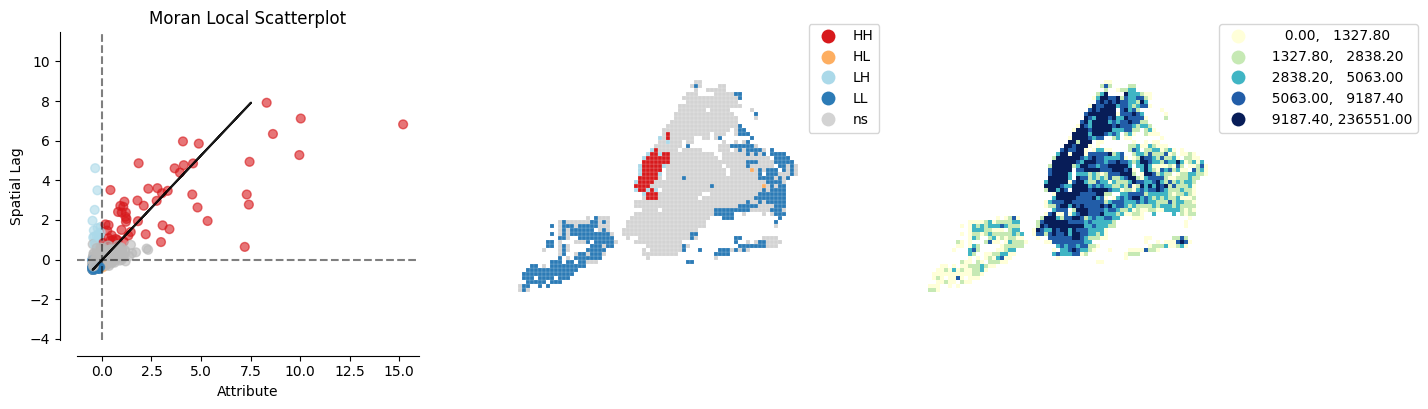

In [144]:
plot_local_autocorrelation(local_moran2, regGrid, 'daytime_po', p=0.05)

In [145]:
# get the clusters and outliers 
regGrid['local_moran_Is'] = local_moran2.Is

In [146]:
regGrid['local_moran_p_value'] = local_moran2.p_sim

In [147]:
regGrid['local_moran_quadrant'] = local_moran2.q

In [150]:
# get the statistically significant clusters and outliers 
alpha = 0.05
hotspots2 = regGrid.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots2 = regGrid.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts2 = regGrid.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamond2 = regGrid.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

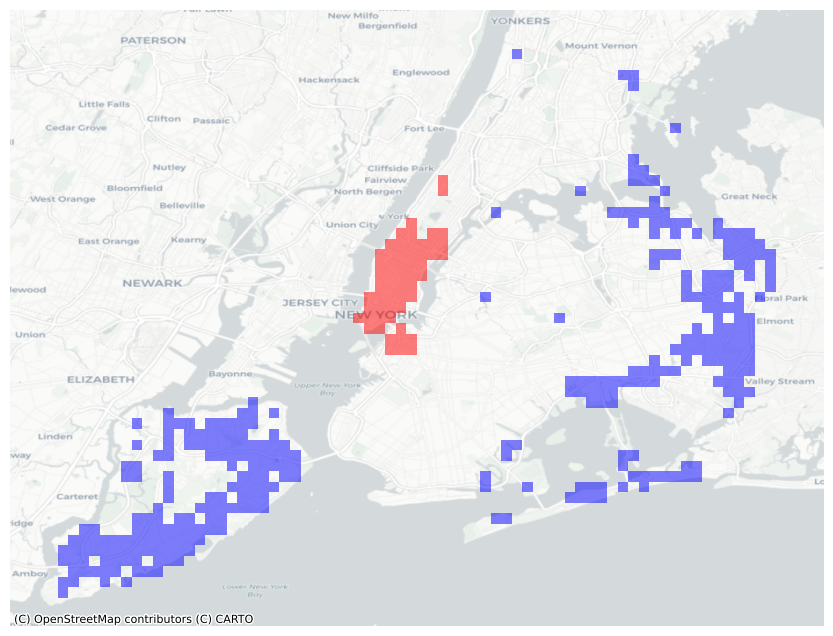

In [153]:
fig, ax = plt.subplots(figsize=(16,8))
regGrid.plot(ax=ax, facecolor='none', alpha=0)
hotspots2.plot(color='red', ax=ax, label='Hot Spot', alpha=.5)
coldspots2.plot(color='blue',ax=ax, label='Cold Spot',alpha=.5)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=4326)
ax.axis('off')
plt.savefig('daytimePop_hotspot_analysis.png', bbox_inches='tight', transparent=True)


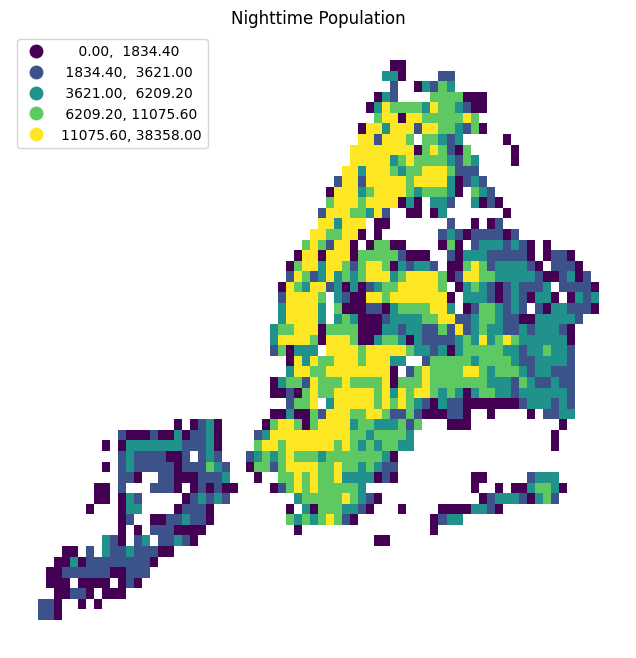

In [155]:
ax = regGrid.plot(column='nighttime_', 
                  scheme='quantiles', 
                  legend=True, 
                  legend_kwds={'loc': 'upper left'})
ax.axis('off')
ax.set_title('Nighttime Population');

In [158]:
regGrid['nighttime_'].isna().value_counts()

nighttime_
False    1235
Name: count, dtype: int64

In [159]:
w3 = weights.Queen.from_dataframe(regGrid)

In [161]:
# w3.weights

In [162]:
w3.transform = 'R'

('WARNING: ', 46, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 688, ' is an island (no neighbors)')


In [163]:
moran3 = esda.moran.Moran(regGrid['nighttime_'], w, permutations=9999)

In [164]:
moran3.I

0.5649674873085619

In [165]:
moran3.p_sim

0.0001

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.56', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.56)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

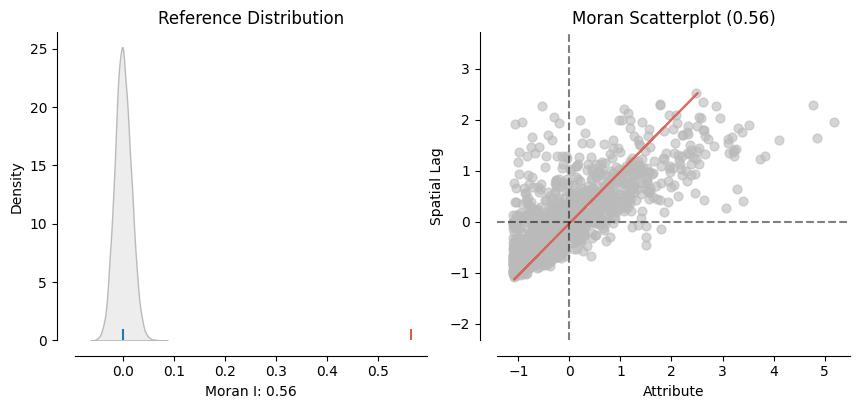

In [166]:
plot_moran(moran3)

In [167]:
w3_dist = weights.DistanceBand.from_dataframe(regGrid, distance_band)

In [168]:
getisord3 = esda.getisord.G(regGrid['nighttime_'], w_dist, permutations=9999)

In [169]:
getisord3.G

1.0

In [170]:
getisord3.z_sim

nan

In [171]:
getisord3.p_sim

0.0001

In [172]:
local_moran3 = esda.moran.Moran_Local(regGrid['nighttime_'], w2)

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <Axes: >, <Axes: >], dtype=object))

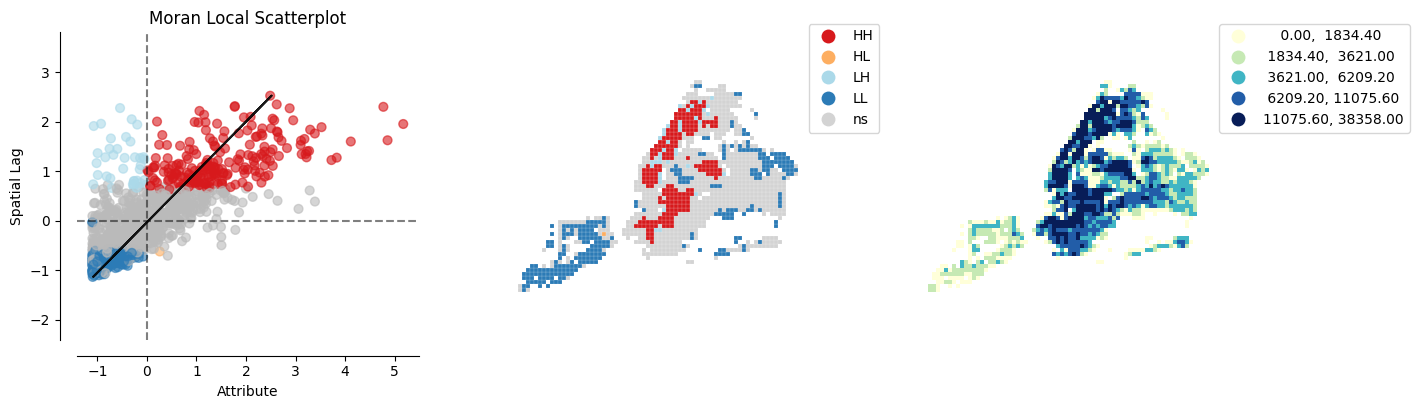

In [173]:
plot_local_autocorrelation(local_moran3, regGrid, 'nighttime_', p=0.05)

In [175]:
regGrid['local_moran_Is'] = local_moran3.Is

In [176]:
regGrid['local_moran_p_value'] = local_moran3.p_sim

In [177]:
regGrid['local_moran_quadrant'] = local_moran3.q

In [178]:
# get the statistically significant clusters and outliers 
alpha = 0.05
hotspots3 = regGrid.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots3 = regGrid.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts3 = regGrid.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamond3 = regGrid.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

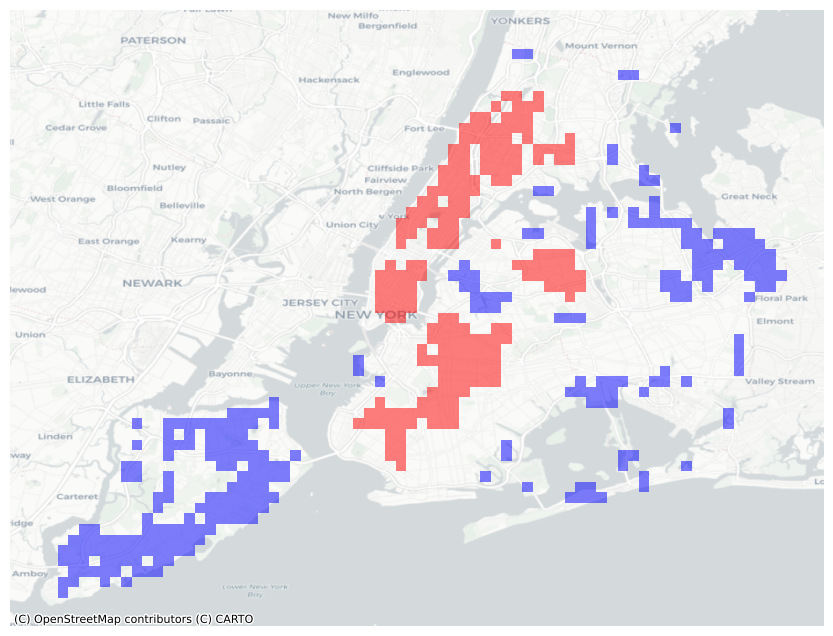

In [179]:
fig, ax = plt.subplots(figsize=(16,8))
regGrid.plot(ax=ax, facecolor='none', alpha=0)
hotspots3.plot(color='red', ax=ax, label='Hot Spot', alpha=.5)
coldspots3.plot(color='blue',ax=ax, label='Cold Spot',alpha=.5)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=4326)
ax.axis('off')
# plt.savefig('nighttimePop_hotspot_analysis.png', bbox_inches='tight', transparent=True)
